In [1]:
import pickle
import rootutils
from pathlib import Path
import sys

root_path = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)

src_path = Path(root_path) / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from tree_builder import TreeBuilder


In [2]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.preprocessing import normalize



In [3]:
def spherical_kmeans(X, n_clusters=2, max_iter=100, tol=1e-4):
    """
    Sua lógica original do tree_builder, isolada e limpa.
    X deve estar normalizado (L2).
    """
    n_samples, n_features = X.shape
    
    # Inicialização aleatória dos centróides (escolhendo pontos existentes)
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[indices].copy()
    
    # Loop de otimização
    for i in range(max_iter):
        old_centroids = centroids.copy()
        
        # 1. Atribuição (Dot Product é similaridade de cosseno em vetores normalizados)
        sim_matrix = np.dot(X, centroids.T)
        labels = np.argmax(sim_matrix, axis=1)
        
        # 2. Atualização
        for k in range(n_clusters):
            members = X[labels == k]
            if len(members) > 0:
                # Média vetorial
                new_center = np.mean(members, axis=0)
                # Renormalizar para voltar à superfície da esfera
                centroids[k] = new_center / np.linalg.norm(new_center)
            else:
                # Re-inicializar se cluster ficar vazio
                centroids[k] = X[np.random.choice(n_samples)]
        
        # Critério de parada (mudança mínima nos centróides)
        diff = np.sum((centroids - old_centroids)**2)
        if diff < tol:
            break
            
    return labels, centroids

In [4]:
def prepare_node_data_strict(path_embeddings, min_samples=3, max_classes=None):
    print(f"--- Processando {path_embeddings} ---")
    
    # Carregar
    with open(path_embeddings, 'rb') as f:
        data = pickle.load(f)
    
    # Garantir formato numpy e normalização inicial
    raw_embeddings = np.array(data['embeddings'])
    if raw_embeddings.ndim == 1: # Correção para listas de listas
         raw_embeddings = np.stack(raw_embeddings)
            
    # Normalização L2 (Fundamental para ASL e Spherical K-Means)
    embeddings = normalize(raw_embeddings, norm='l2', axis=1)
    names = np.array(data['nomes'])
    
    # --- FILTRAGEM (CRÍTICA) ---
    counts = Counter(names)
    unique_names = list(counts.keys())
    
    # Regra: < 3 vira Background (Unknown)
    bg_names = set([n for n in unique_names if counts[n] < min_samples])
    # Regra: >= 3 vira Known (Galeria)
    known_names = [n for n in unique_names if counts[n] >= min_samples]
    
    # Reduzir classes se solicitado pelo orientador
    if max_classes and len(known_names) > max_classes:
        print(f"AVISO: Limitando de {len(known_names)} para {max_classes} classes conhecidas.")
        known_names = known_names[:max_classes]
    
    known_set = set(known_names)
    
    print(f"Estatísticas:")
    print(f" -> Identidades Background (<{min_samples} imgs): {len(bg_names)}")
    print(f" -> Identidades Conhecidas (>={min_samples} imgs): {len(known_set)}")

    # Separar os dados brutos
    X_known = []
    y_known_names = []
    X_bg = []
    
    # Agrupamento para cálculo do centróide da classe
    class_vectors = {n: [] for n in known_set}
    
    for emb, name in zip(embeddings, names):
        if name in known_set:
            X_known.append(emb)
            y_known_names.append(name)
            class_vectors[name].append(emb)
        elif name in bg_names:
            X_bg.append(emb) # Esses caras vão ter label -1 (Origem)
            
    X_known = np.array(X_known)
    X_bg = np.array(X_bg)
    
    if len(X_known) == 0:
        raise ValueError("Nenhuma classe conhecida encontrada com os critérios atuais.")

    # --- CLUSTERIZAÇÃO (DIVISÃO ESQUERDA/DIREITA) ---
    # Calculamos 1 centróide por CLASSE CONHECIDA para dividir as classes, não as imagens.
    print("Calculando centróides das classes...")
    class_centroids_arr = []
    ordered_known_names = []
    
    for name in known_names:
        vecs = np.array(class_vectors[name])
        # Centróide da classe
        c = np.mean(vecs, axis=0)
        c = c / np.linalg.norm(c)
        class_centroids_arr.append(c)
        ordered_known_names.append(name)
        
    class_centroids_arr = np.array(class_centroids_arr)
    
    print(f"Rodando Spherical K-Means em {len(class_centroids_arr)} classes...")
    # AQUI ESTÁ O SEU SPHERICAL K-MEANS SENDO USADO
    labels_clustering, _ = spherical_kmeans(class_centroids_arr, n_clusters=2)
    
    # Mapa: Nome -> 0 (Esq) ou 1 (Dir)
    side_map = {name: lbl for name, lbl in zip(ordered_known_names, labels_clustering)}
    
    # Contagem
    n_left = np.sum(labels_clustering == 0)
    n_right = np.sum(labels_clustering == 1)
    print(f" -> Divisão: {n_left} Classes na Esquerda | {n_right} Classes na Direita")
    
    # --- MONTAGEM FINAL DO DATASET ---
    final_X = []
    final_Y = [] # 0, 1, ou -1
    
    # Adiciona Knowns
    for emb, name in zip(X_known, y_known_names):
        final_X.append(emb)
        final_Y.append(side_map[name])
        
    # Adiciona Background (Unknowns Reais)
    # ATENÇÃO: Se não tiver background real, a rede não aprende rejeição.
    if len(X_bg) > 0:
        for emb in X_bg:
            final_X.append(emb)
            final_Y.append(-1)
    else:
        print("ALERTA CRÍTICO: Nenhum dado de background (identidades com poucas fotos). A rede não vai aprender a rejeitar!")

    return np.array(final_X), np.array(final_Y), side_map

In [5]:
EMBEDDINGS_FILE = root_path / "data" / "lfw_embeddings_processados.pkl"

# Roda a preparação
X_train, y_train, map_lados = prepare_node_data_strict(
    EMBEDDINGS_FILE, 
    min_samples=3,  # Regra de corte
    max_classes=875  # Teste pequeno
)

# Cria DataLoader simples
train_ds = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(y_train)
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

print("\n--- Pronto para Treino ---")
print(f"Total Amostras: {len(y_train)}")
print(f"Exemplo Batch: {next(iter(train_loader))[1][:10]}")

--- Processando C:\Users\pedro\OneDrive\Documentos\git\h-asl-thesis\data\lfw_embeddings_processados.pkl ---
Estatísticas:
 -> Identidades Background (<3 imgs): 805
 -> Identidades Conhecidas (>=3 imgs): 875
Calculando centróides das classes...
Rodando Spherical K-Means em 875 classes...
 -> Divisão: 468 Classes na Esquerda | 407 Classes na Direita

--- Pronto para Treino ---
Total Amostras: 8929
Exemplo Batch: tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1])


Rodando em: cpu

--- Iniciando Treinamento do Nó Raiz ---
Época 010 | Loss: 1.1972 | Acc Conhecidos: 92.9%
Época 020 | Loss: 1.1570 | Acc Conhecidos: 93.8%
Época 030 | Loss: 1.0000 | Acc Conhecidos: 95.5%
Época 040 | Loss: 0.8573 | Acc Conhecidos: 97.3%
Época 050 | Loss: 0.8208 | Acc Conhecidos: 97.9%
Época 060 | Loss: 0.8165 | Acc Conhecidos: 97.8%
Época 070 | Loss: 0.7060 | Acc Conhecidos: 98.9%
Época 080 | Loss: 0.7254 | Acc Conhecidos: 98.8%
Época 090 | Loss: 0.8436 | Acc Conhecidos: 97.8%
Época 100 | Loss: 0.6687 | Acc Conhecidos: 99.2%
Época 110 | Loss: 0.6209 | Acc Conhecidos: 99.5%
Época 120 | Loss: 0.6078 | Acc Conhecidos: 99.5%
Época 130 | Loss: 0.5606 | Acc Conhecidos: 99.7%
Época 140 | Loss: 0.5641 | Acc Conhecidos: 99.7%
Época 150 | Loss: 0.5446 | Acc Conhecidos: 99.7%
Época 160 | Loss: 0.5545 | Acc Conhecidos: 99.6%
Época 170 | Loss: 0.5645 | Acc Conhecidos: 99.5%
Época 180 | Loss: 0.5070 | Acc Conhecidos: 99.9%
Época 190 | Loss: 0.4964 | Acc Conhecidos: 99.8%
Época 200 |

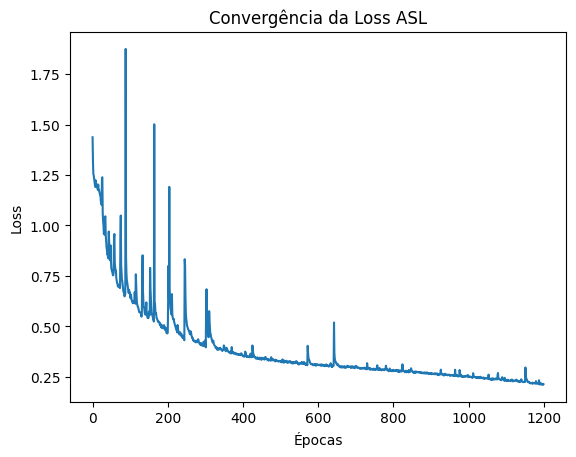

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. A REDE (ADAPTER) - Simples e Direta
# ==========================================
class NodeNetwork(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        # Arquitetura do artigo ASL: 512 -> 256 -> 256 -> 2
        # (Aumentei um pouco a largura conforme sugestão do seu orientador)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(), # Tanh é crucial para ASL
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(256, 2), # Saída 2D (Esquerda/Direita)
        )

    def forward(self, x):
        return self.fc(x)

# ==========================================
# 2. A LOSS ASL (Adaptada para rodar aqui)
# ==========================================
class AxialSpheresLoss(nn.Module):
    def __init__(self, alpha=10.0, beta=0.1, gamma=0.1): # Beta/Gamma ajustados
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        # Eixos fixos: Esquerda=[alpha, 0], Direita=[0, alpha]
        self.centers = torch.tensor([
            [alpha, 0.0], 
            [0.0, alpha]
        ]).float()

    def forward(self, logits, targets):
        self.centers = self.centers.to(logits.device)
        
        # Separar quem é Known (0 ou 1) de quem é Unknown (-1)
        known_mask = (targets >= 0)
        unknown_mask = (targets < 0)
        
        loss = 0.0
        
        # --- PARTE 1: CONHECIDOS (ESQ/DIR) ---
        if known_mask.any():
            k_logits = logits[known_mask]
            k_targets = targets[known_mask]
            
            # Pegar o centro correto para cada amostra
            target_centers = self.centers[k_targets] 
            
            # A. Intra-class (Atração): Puxar pro seu centro
            d_intra = torch.norm(k_logits - target_centers, p=2, dim=1)
            
            # B. Inter-class (Repulsão): Afastar do OUTRO centro
            # Truque rápido para 2 classes: O "outro" é 1 - target
            other_centers = self.centers[1 - k_targets]
            d_inter = torch.norm(k_logits - other_centers, p=2, dim=1)
            
            # Loss Inter (queremos maximizar d_inter, então minimizamos exp(d_intra - d_inter))
            l_inter = torch.exp(d_intra - d_inter).mean()
            l_intra = d_intra.mean()
            
            loss += l_inter + self.beta * l_intra

        # --- PARTE 2: DESCONHECIDOS (ORIGEM) ---
        if unknown_mask.any():
            uk_logits = logits[unknown_mask]
            # C. Magnitude (Puxar pra zero)
            mag = torch.norm(uk_logits, p=2, dim=1)
            l_mag = mag.mean()
            
            loss += self.gamma * l_mag
            
        return loss

# ==========================================
# 3. LOOP DE TREINAMENTO COM GRÁFICOS
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Rodando em: {device}")

model = NodeNetwork().to(device)
criterion = AxialSpheresLoss(alpha=10.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 1200
loss_history = []

print("\n--- Iniciando Treinamento do Nó Raiz ---")
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct_known = 0
    total_known = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calcular acurácia apenas nos Conhecidos (0 e 1) pra ver se tá aprendendo a dividir
        known_mask = (batch_y >= 0)
        if known_mask.any():
            # Quem tá mais perto de [alpha,0] é 0, quem tá perto de [0,alpha] é 1
            # Truque: Se x > y -> 0 (Esq), se y > x -> 1 (Dir)
            preds = (logits[known_mask, 1] > logits[known_mask, 0]).long()
            correct_known += (preds == batch_y[known_mask]).sum().item()
            total_known += known_mask.sum().item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    acc = (correct_known / total_known * 100) if total_known > 0 else 0.0
    
    if (epoch+1) % 10 == 0:
        print(f"Época {epoch+1:03d} | Loss: {avg_loss:.4f} | Acc Conhecidos: {acc:.1f}%")

# Plotar Loss
plt.plot(loss_history)
plt.title("Convergência da Loss ASL")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

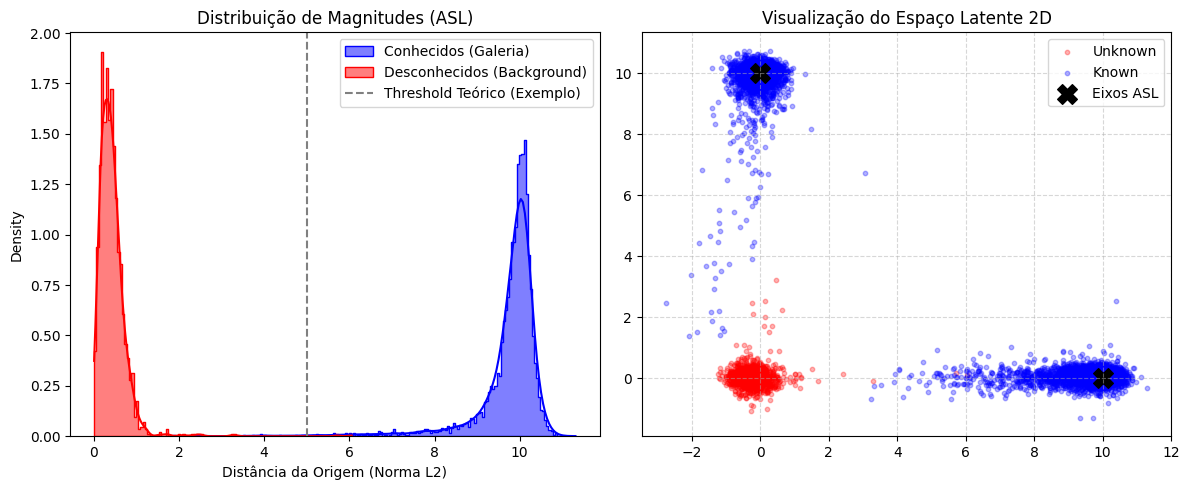

Média Magnitude Conhecidos: 9.7267 (Ideal: próximo de 10)
Média Magnitude Desconhecidos: 0.4284 (Ideal: próximo de 0)


In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns

def analyze_magnitudes(model, loader, device):
    model.eval()
    
    # Listas para guardar as magnitudes (norma L2) dos vetores de saída
    mags_known = []
    mags_unknown = []
    
    # Cores para o plot
    logits_x = []
    logits_y = []
    labels = []

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            
            # Passar pela rede treinada
            logits = model(batch_X) # Saída 2D
            
            # Calcular magnitude (distância da origem)
            magnitudes = torch.norm(logits, p=2, dim=1).cpu().numpy()
            current_labels = batch_y.cpu().numpy()
            
            # Separar Conhecidos (>=0) de Desconhecidos (-1)
            for mag, label, logit in zip(magnitudes, current_labels, logits.cpu().numpy()):
                if label >= 0:
                    mags_known.append(mag)
                    labels.append(f"Classe {label} (Known)")
                else:
                    mags_unknown.append(mag)
                    labels.append("Unknown/Background")
                
                # Guardar para scatter plot
                logits_x.append(logit[0])
                logits_y.append(logit[1])

    # --- PLOT 1: HISTOGRAMA DE MAGNITUDES (A PROVA DE FOGO) ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(mags_known, color='blue', label='Conhecidos (Galeria)', kde=True, stat="density", element="step")
    sns.histplot(mags_unknown, color='red', label='Desconhecidos (Background)', kde=True, stat="density", element="step")
    plt.title("Distribuição de Magnitudes (ASL)")
    plt.xlabel("Distância da Origem (Norma L2)")
    plt.axvline(x=5.0, color='gray', linestyle='--', label='Threshold Teórico (Exemplo)')
    plt.legend()
    
    # --- PLOT 2: ESPAÇO LATENTE 2D ---
    plt.subplot(1, 2, 2)
    # Converter para numpy
    lx = np.array(logits_x)
    ly = np.array(logits_y)
    lbls = np.array(labels)
    
    # Plot Unknowns (Vermelho, perto da origem)
    mask_unk = np.char.find(lbls, "Unknown") >= 0
    plt.scatter(lx[mask_unk], ly[mask_unk], c='red', alpha=0.3, s=10, label='Unknown')
    
    # Plot Knowns (Azul/Verde, perto dos eixos)
    mask_k = ~mask_unk
    plt.scatter(lx[mask_k], ly[mask_k], c='blue', alpha=0.3, s=10, label='Known')
    
    # Desenhar os Eixos Alvo (Alpha=10)
    plt.scatter([10, 0], [0, 10], c='black', marker='X', s=200, label='Eixos ASL')
    
    plt.title("Visualização do Espaço Latente 2D")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Média Magnitude Conhecidos: {np.mean(mags_known):.4f} (Ideal: próximo de 10)")
    print(f"Média Magnitude Desconhecidos: {np.mean(mags_unknown):.4f} (Ideal: próximo de 0)")

# RODAR ANÁLISE
analyze_magnitudes(model, train_loader, device)

--- Iniciando Auditoria Completa ---

=== RELATÓRIO DE AUDITORIA ===
1. Capacidade de Distinguir Conhecido vs Desconhecido (AUROC): 1.0000
   (1.0 = Perfeito, 0.5 = Chute Aleatório)
   -> Melhor Threshold Sugerido: 3.31

2. Simulação com Threshold = 3.31
   -> Acurácia Geral (Open-Set): 99.88%
   -> Erros Críticos:
      - Deixou entrar Desconhecido (FAR): 0.13%
      - Barrou Conhecido (FRR): 0.12%
      - Aceitou Conhecido mas errou o lado: 0.00%


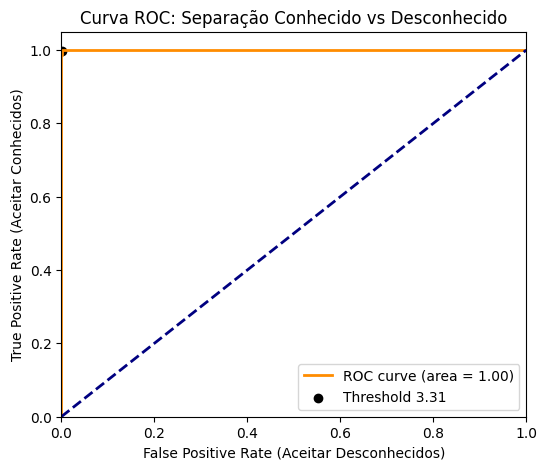

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

def audit_model(model, loader, device):
    model.eval()
    
    # Listas para guardar tudo
    all_magnitudes = []
    all_preds_side = [] # 0 ou 1 (quem o modelo acha que é, se for conhecido)
    all_labels_type = [] # 1 se for Conhecido, 0 se for Desconhecido (Binário para ROC)
    all_labels_side = [] # 0 ou 1 (Lado real, -1 se for background)
    
    print("--- Iniciando Auditoria Completa ---")
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            
            # Forward
            logits = model(batch_X)
            
            # 1. Calcular Magnitude (A "Força" da predição)
            mags = torch.norm(logits, p=2, dim=1).cpu().numpy()
            
            # 2. Decidir o Lado (Esq vs Dir) - Independente da magnitude
            # Se x > y -> 0, senão 1
            preds = (logits[:, 1] > logits[:, 0]).long().cpu().numpy()
            
            labels = batch_y.cpu().numpy()
            
            for m, p, l in zip(mags, preds, labels):
                all_magnitudes.append(m)
                all_preds_side.append(p)
                all_labels_side.append(l)
                
                # Para a Curva ROC: Conhecido (>=0) é Classe Positiva (1)
                # Desconhecido (-1) é Classe Negativa (0)
                is_known = 1 if l >= 0 else 0
                all_labels_type.append(is_known)

    # Converter para numpy
    magnitudes = np.array(all_magnitudes)
    y_true_type = np.array(all_labels_type) # 1=Known, 0=Unknown
    y_true_side = np.array(all_labels_side)
    y_pred_side = np.array(all_preds_side)

    # --- ANÁLISE 1: CURVA ROC (Capacidade de Rejeição) ---
    fpr, tpr, thresholds = roc_curve(y_true_type, magnitudes)
    roc_auc = auc(fpr, tpr)
    
    # Achar o melhor threshold (ponto mais próximo do canto superior esquerdo)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\n=== RELATÓRIO DE AUDITORIA ===")
    print(f"1. Capacidade de Distinguir Conhecido vs Desconhecido (AUROC): {roc_auc:.4f}")
    print(f"   (1.0 = Perfeito, 0.5 = Chute Aleatório)")
    print(f"   -> Melhor Threshold Sugerido: {optimal_threshold:.2f}")

    # --- ANÁLISE 2: ACURÁCIA NO MELHOR THRESHOLD ---
    # Vamos aplicar esse threshold e ver o que acontece
    print(f"\n2. Simulação com Threshold = {optimal_threshold:.2f}")
    
    # Classificação Final:
    # Se mag < threshold -> Predição é -1 (Rejeitado)
    # Se mag >= threshold -> Predição é o lado (0 ou 1)
    final_preds = []
    for mag, side in zip(magnitudes, y_pred_side):
        if mag < optimal_threshold:
            final_preds.append(-1)
        else:
            final_preds.append(side)
    final_preds = np.array(final_preds)
    
    # Calcular erros
    # A. Conhecidos que foram rejeitados (Falso Negativo de Identidade)
    mask_known = (y_true_side >= 0)
    frr = np.mean(final_preds[mask_known] == -1)
    
    # B. Desconhecidos que foram aceitos (Falso Alarme)
    mask_unknown = (y_true_side == -1)
    far = np.mean(final_preds[mask_unknown] != -1)
    
    # C. Conhecidos que foram aceitos MAS classificados no lado errado
    # (Só conta quem NÃO foi rejeitado)
    accepted_known_mask = (mask_known) & (final_preds != -1)
    if accepted_known_mask.sum() > 0:
        # Dos aceitos, quantos erraram o lado?
        wrong_side = np.mean(final_preds[accepted_known_mask] != y_true_side[accepted_known_mask])
    else:
        wrong_side = 0.0
        
    # D. Acurácia Total (DIR - Detection and Identification Rate)
    # Acertou ser conhecido E acertou o lado
    correct_identification = (final_preds == y_true_side)
    # Para desconhecidos, acertar significa ser rejeitado (-1)
    
    total_acc = np.mean(correct_identification)

    print(f"   -> Acurácia Geral (Open-Set): {total_acc*100:.2f}%")
    print(f"   -> Erros Críticos:")
    print(f"      - Deixou entrar Desconhecido (FAR): {far*100:.2f}%")
    print(f"      - Barrou Conhecido (FRR): {frr*100:.2f}%")
    print(f"      - Aceitou Conhecido mas errou o lado: {wrong_side*100:.2f}%")

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Threshold {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Aceitar Desconhecidos)')
    plt.ylabel('True Positive Rate (Aceitar Conhecidos)')
    plt.title('Curva ROC: Separação Conhecido vs Desconhecido')
    plt.legend(loc="lower right")
    plt.show()

# RODAR
audit_model(model, train_loader, device)

In [3]:
import sys
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import normalize
from pathlib import Path

# --- CONFIGURAÇÃO DE CAMINHO ---
# Adiciona o diretório raiz ao path para importar 'src'
# Ajuste o '../' se necessário
current_dir = Path(os.getcwd())
root_dir = current_dir.parent # Assume que notebooks/ está dentro da raiz
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# IMPORTANDO SEUS MÓDULOS DE PRODUÇÃO
from src.tree_builder import TreeBuilder
from src.models.neural_networks.node_network import NodeNetwork
from src.models.losses.asl import AxialSpheresLoss

print("✅ Módulos do 'src' importados com sucesso!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Rodando em: {device}")

✅ Módulos do 'src' importados com sucesso!
🖥️ Rodando em: cpu


In [4]:
# --- PARÂMETROS ---
# Ajuste o caminho para onde seu arquivo realmente está
DATA_PATH = root_dir / 'data' / 'lfw_embeddings_processados.pkl' 
MIN_SAMPLES = 3

print(f"--- Processando Dados (Baseado em teste_pos_vareto.ipynb) ---")

# 1. Usar o TreeBuilder para carregar, filtrar e decidir a estrutura da árvore
# O TreeBuilder já faz internamente o 'prepare_node_data_strict' para criar a árvore
builder = TreeBuilder(
    embeddings_path=str(DATA_PATH),
    min_samples=MIN_SAMPLES,
    max_classes=875 # Seu teste pequeno
)

# Constrói a árvore (Calcula centróides -> Spherical K-Means -> Define Left/Right)
builder.build_tree()
root = builder.root

print(f"\n🌳 Estrutura do Nó Raiz Definida:")
print(f"   Esquerda (Label 0): {len(root.left.identities)} classes")
print(f"   Direita  (Label 1): {len(root.right.identities)} classes")
print(f"   Background (Label -1): {len(builder.background_data)} amostras (filtradas < {MIN_SAMPLES})")

# 2. Montar o Dataset de Treino (Recuperando as Instâncias Brutas)
# Precisamos re-ler o arquivo ou usar os dados internos do builder se ele guardasse tudo (ele guarda background, mas não known brutos)
# Então vamos re-ler para garantir que pegamos TODAS as imagens das classes selecionadas
with open(DATA_PATH, 'rb') as f:
    raw_data = pickle.load(f)

# Normalização L2 (Vital para ASL)
raw_embeddings = np.array(raw_data['embeddings'])
if raw_embeddings.ndim == 1: raw_embeddings = np.stack(raw_embeddings)
all_embeddings = normalize(raw_embeddings, norm='l2', axis=1)
all_names = np.array(raw_data['nomes'])

# Sets para busca rápida O(1) - Quem o TreeBuilder decidiu que é Esq ou Dir?
left_names = set(root.left.identities)
right_names = set(root.right.identities)

X_train = []
y_train = []

print("\n--- Montando Dataset com Embeddings Brutos ---")
# Loop pelas instâncias brutas (Exatamente como no seu notebook)
for emb, name in zip(all_embeddings, all_names):
    if name in left_names:
        X_train.append(emb)
        y_train.append(0) # Esquerda
    elif name in right_names:
        X_train.append(emb)
        y_train.append(1) # Direita
    # Se não está em left/right, ou foi filtrado (background) ou excedeu max_classes

# Adicionar Background (Unknowns) vindo do TreeBuilder (já filtrados e guardados)
for emb in builder.background_data:
    X_train.append(emb)
    y_train.append(-1)

# Converter para Tensores
X_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_tensor = torch.tensor(np.array(y_train), dtype=torch.long)

# DataLoader
train_ds = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

print("\n📦 Dataset Pronto para Treino:")
print(f"   Total Amostras: {len(y_train)}")
print(f"   Known (0/1): {(y_tensor >= 0).sum().item()}")
print(f"   Unknown (-1): {(y_tensor == -1).sum().item()}")
print(f"   Exemplo Batch Labels: {next(iter(train_loader))[1][:10]}")

--- Processando Dados (Baseado em teste_pos_vareto.ipynb) ---
Starting TreeBuilder with strict Open-Set logic...
   -> Loading embeddings from 'c:\Users\pedro\OneDrive\Documentos\git\h-asl-thesis\data\lfw_embeddings_processados.pkl'...
Estatísticas:
 -> Identidades Background (<3 imgs): 805
 -> Identidades Conhecidas (>=3 imgs): 875
Calculando centróides das classes conhecidas...

 Iniciando a construção da Árvore Hierárquica...
I-> Clusterizando 875 classes no nível 0...
  I-> Clusterizando 443 classes no nível 1...
    I-> Clusterizando 225 classes no nível 2...
      I-> Clusterizando 87 classes no nível 3...
        I-> Clusterizando 37 classes no nível 4...
          I-> Clusterizando 15 classes no nível 5...
            I-> Clusterizando 2 classes no nível 6...
              L-> Nó Folha criado com 1 identidade(s).
              L-> Nó Folha criado com 1 identidade(s).
            I-> Clusterizando 13 classes no nível 6...
              I-> Clusterizando 4 classes no nível 7...
 

In [5]:
# --- INICIALIZAÇÃO DO MODELO ---
print("🚀 Inicializando Rede H-ASL (Módulos de Produção)...")

# Rede do Nó (NodeNetwork do src)
# A arquitetura é idêntica à do notebook: 512 -> 256 -> 256 -> 2
model = NodeNetwork(input_dim=512).to(device)

# Loss ASL (AxialSpheresLoss do src)
# Usando os parâmetros do notebook: Alpha=10, Gamma=0.1
criterion = AxialSpheresLoss(
    num_classes=2,
    alpha=10.0, 
    beta=0.1, 
    gamma=0.1 
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)
print("Loss configurada com Alpha=10.0, Beta=0.1, Gamma=0.1")

🚀 Inicializando Rede H-ASL (Módulos de Produção)...
NodeNetwork(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)
Loss configurada com Alpha=10.0, Beta=0.1, Gamma=0.1



🔥 Iniciando Treinamento...
Época 0100 | Loss: 0.4213 | Acc Conhecidos: 99.7%
Época 0200 | Loss: 0.3542 | Acc Conhecidos: 99.9%
Época 0300 | Loss: 0.3328 | Acc Conhecidos: 99.9%
Época 0400 | Loss: 0.3094 | Acc Conhecidos: 100.0%
Época 0500 | Loss: 0.2980 | Acc Conhecidos: 100.0%
Época 0600 | Loss: 0.2844 | Acc Conhecidos: 100.0%
Época 0700 | Loss: 0.2743 | Acc Conhecidos: 100.0%
Época 0800 | Loss: 0.2626 | Acc Conhecidos: 100.0%
Época 0900 | Loss: 0.2536 | Acc Conhecidos: 100.0%
Época 1000 | Loss: 0.2352 | Acc Conhecidos: 100.0%
Época 1100 | Loss: 0.2148 | Acc Conhecidos: 100.0%
Época 1200 | Loss: 0.1914 | Acc Conhecidos: 100.0%
✅ Treino Finalizado!


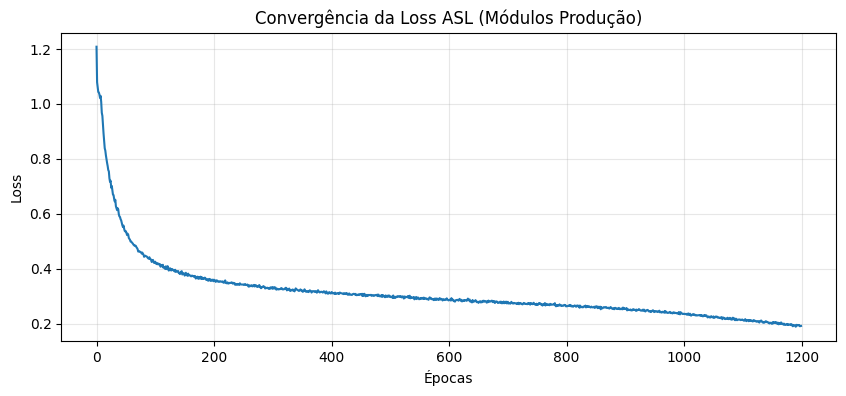

In [6]:
# --- LOOP DE TREINAMENTO ---
EPOCHS = 1200 # Igual ao notebook
loss_history = []

print("\n🔥 Iniciando Treinamento...")
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct_known = 0
    total_known = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        logits = model(batch_X)
        
        # Loss (A mágica acontece dentro do asl.py agora)
        loss = criterion(logits, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calcular acurácia apenas nos Conhecidos
        known_mask = (batch_y >= 0)
        if known_mask.any():
            # Decisão binária simples: quem é maior? dim 0 ou dim 1?
            preds = (logits[known_mask, 1] > logits[known_mask, 0]).long()
            correct_known += (preds == batch_y[known_mask]).sum().item()
            total_known += known_mask.sum().item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    acc = (correct_known / total_known * 100) if total_known > 0 else 0.0
    
    if (epoch+1) % 100 == 0: # Print a cada 100 pra não poluir
        print(f"Época {epoch+1:04d} | Loss: {avg_loss:.4f} | Acc Conhecidos: {acc:.1f}%")

print("✅ Treino Finalizado!")

# Plotar Curva de Aprendizado
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Convergência da Loss ASL (Módulos Produção)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

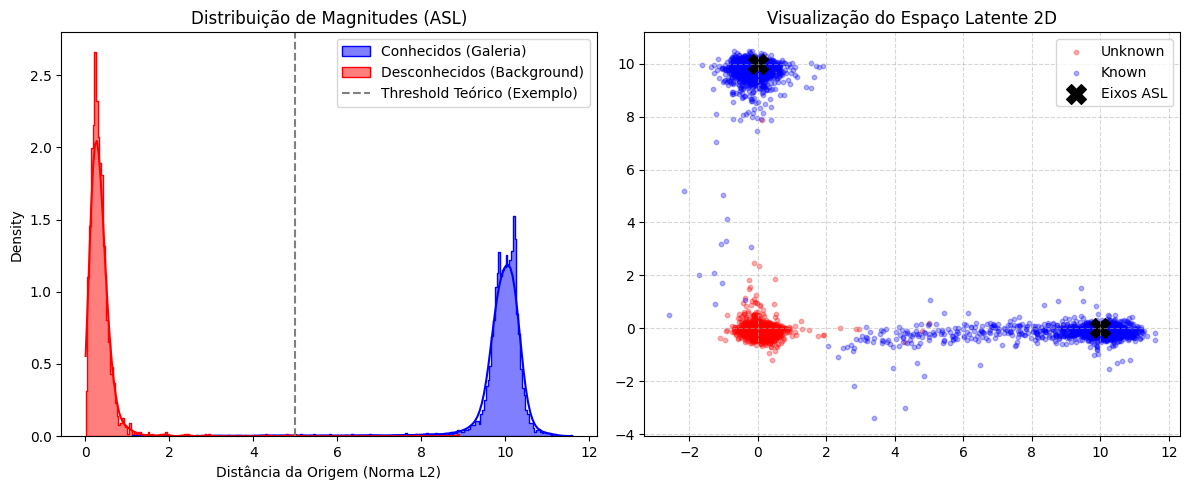

Média Magnitude Conhecidos: 9.8624 (Ideal: próximo de 10)
Média Magnitude Desconhecidos: 0.3608 (Ideal: próximo de 0)


In [7]:
# --- ANÁLISE DE MAGNITUDES E ESPAÇO LATENTE ---
# Copiei exatamente a sua função de análise do notebook

def analyze_magnitudes(model, loader, device):
    model.eval()
    
    # Listas para guardar as magnitudes (norma L2) dos vetores de saída
    mags_known = []
    mags_unknown = []
    
    # Cores para o plot
    logits_x = []
    logits_y = []
    labels = []

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            
            # Passar pela rede treinada
            logits = model(batch_X) # Saída 2D
            
            # Calcular magnitude (distância da origem)
            magnitudes = torch.norm(logits, p=2, dim=1).cpu().numpy()
            current_labels = batch_y.cpu().numpy()
            
            # Separar Conhecidos (>=0) de Desconhecidos (-1)
            for mag, label, logit in zip(magnitudes, current_labels, logits.cpu().numpy()):
                if label >= 0:
                    mags_known.append(mag)
                    labels.append(f"Classe {label} (Known)")
                else:
                    mags_unknown.append(mag)
                    labels.append("Unknown/Background")
                
                # Guardar para scatter plot
                logits_x.append(logit[0])
                logits_y.append(logit[1])

    # --- PLOT 1: HISTOGRAMA DE MAGNITUDES (A PROVA DE FOGO) ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(mags_known, color='blue', label='Conhecidos (Galeria)', kde=True, stat="density", element="step")
    sns.histplot(mags_unknown, color='red', label='Desconhecidos (Background)', kde=True, stat="density", element="step")
    plt.title("Distribuição de Magnitudes (ASL)")
    plt.xlabel("Distância da Origem (Norma L2)")
    plt.axvline(x=5.0, color='gray', linestyle='--', label='Threshold Teórico (Exemplo)')
    plt.legend()
    
    # --- PLOT 2: ESPAÇO LATENTE 2D ---
    plt.subplot(1, 2, 2)
    # Converter para numpy
    lx = np.array(logits_x)
    ly = np.array(logits_y)
    lbls = np.array(labels)
    
    # Plot Unknowns (Vermelho, perto da origem)
    mask_unk = np.char.find(lbls, "Unknown") >= 0
    plt.scatter(lx[mask_unk], ly[mask_unk], c='red', alpha=0.3, s=10, label='Unknown')
    
    # Plot Knowns (Azul/Verde, perto dos eixos)
    mask_k = ~mask_unk
    plt.scatter(lx[mask_k], ly[mask_k], c='blue', alpha=0.3, s=10, label='Known')
    
    # Desenhar os Eixos Alvo (Alpha=10)
    plt.scatter([10, 0], [0, 10], c='black', marker='X', s=200, label='Eixos ASL')
    
    plt.title("Visualização do Espaço Latente 2D")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Média Magnitude Conhecidos: {np.mean(mags_known):.4f} (Ideal: próximo de 10)")
    print(f"Média Magnitude Desconhecidos: {np.mean(mags_unknown):.4f} (Ideal: próximo de 0)")

# RODAR ANÁLISE
analyze_magnitudes(model, train_loader, device)